In [77]:
# This line configures matplotlib to show figures embedded in the notebook.
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import cross_val_score
#import folium
#import geopandas as gpd

Source: [CDC: Chronic Disease Indicators](https://www.cdc.gov/cdi/index.html)

In [7]:
usecols = ['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1' ]

df = pd.read_csv("U.S._Chronic_Disease_Indicators__CDI_.csv", 
                 usecols=usecols, dtype={'DataValue': 'object'})

df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,US,United States,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,16.9,...,18.0,Overall,Overall,NaN,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,AL,Alabama,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,13.0,...,14.1,Overall,Overall,"(32.84057112200048, -86.63186076199969)",1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,AK,Alaska,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,18.2,...,20.6,Overall,Overall,"(64.84507995700051, -147.72205903599973)",2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,AZ,Arizona,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.6,...,16.9,Overall,Overall,"(34.865970280000454, -111.76381127699972)",4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,AR,Arkansas,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.0,...,17.2,Overall,Overall,"(34.74865012400045, -92.27449074299966)",5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


In [8]:
# Extract location-related attributes into a location table.
dfLocs = df[['LocationID', 'GeoLocation', 'LocationAbbr', 'LocationDesc']]\
    .set_index('LocationID').groupby('LocationID').first()

# Split GeoLocation string into Latitude and Longitude floats
geoLocs = dfLocs['GeoLocation'].str[1:-1].str.split(',', expand=True).astype('float')
geoLocs.columns=['Latitude', 'Longitude']
# Combine Lat/Long into Locations table, and drop unused column.
dfLocs = (pd.concat([dfLocs, geoLocs], axis=1)).drop('GeoLocation', axis=1)
dfLocs.head()

,LocationAbbr,LocationDesc,Latitude,Longitude
LocationID,,,,
1,AL,Alabama,32.840571,-86.631861
2,AK,Alaska,64.845080,-147.722059
4,AZ,Arizona,34.865970,-111.763811
5,AR,Arkansas,34.748650,-92.274491
6,CA,California,37.638640,-121.000000


In [9]:
# Extract topic attributes into a topic table.
dfTopics = df[['TopicID', 'Topic']].groupby('TopicID').first()
dfTopics.head()

,Topic
TopicID,
ALC,Alcohol
ART,Arthritis
AST,Asthma
CAN,Cancer
CKD,Chronic Kidney Disease


In [10]:
# Extract question attributes into a question table.
dfQuestions = df[['QuestionID', 'Question']].groupby('QuestionID').first()
dfQuestions.head()

,Question
QuestionID,
ALC10_0,Local authority to regulate alcohol outlet den...
ALC1_1,Alcohol use among youth
ALC1_2,Alcohol use before pregnancy
ALC2_1,Binge drinking prevalence among youth
ALC2_2,Binge drinking prevalence among adults aged >=...


In [11]:
# Extract Stratification attributes into a Stratification table.
dfStrats = df[['StratificationID1', 'Stratification1']].groupby('StratificationID1').first()
dfStrats

,Stratification1
StratificationID1,
AIAN,American Indian or Alaska Native
API,Asian or Pacific Islander
ASN,"Asian, non-Hispanic"
BLK,"Black, non-Hispanic"
GENF,Female
GENM,Male
HIS,Hispanic
MRC,"Multiracial, non-Hispanic"
OTH,"Other, non-Hispanic"


In [12]:
# Extract StratificationCategory attributes into a StratificationCategory table.
dfStratCats = df[['StratificationCategoryID1', 'StratificationCategory1']] \
    .groupby('StratificationCategoryID1').first()
dfStratCats

,StratificationCategory1
StratificationCategoryID1,
GENDER,Gender
OVERALL,Overall
RACE,Race/Ethnicity


In [13]:
# Extract DataValueType attributes into a DataValueType table.
dfDataValueTypes = df[['DataValueTypeID', 'DataValueType', 'DataValueUnit']]\
    .groupby('DataValueTypeID').first()
dfDataValueTypes

,DataValueType,DataValueUnit
DataValueTypeID,,
AgeAdjMean,Age-adjusted Mean,Number
AgeAdjPrev,Age-adjusted Prevalence,%
AgeAdjRate,Age-adjusted Rate,"cases per 10,000"
AgeSexRaceAdjRate,"Adjusted by age, sex, race and ethnicity","cases per 1,000,000"
AvgAnnAgeAdjRate,Average Annual Age-adjusted Rate,"per 100,000"
AvgAnnCrdRate,Average Annual Crude Rate,"per 100,000"
AvgAnnNmbr,Average Annual Number,NaN
CommHstLiab,Commercial host (dram shop) liability status f...,NaN
CrdPrev,Crude Prevalence,%


In [14]:
dfData = df.drop(['GeoLocation', 'LocationAbbr', 'LocationDesc', 'Topic', 'Question', 
    'Stratification1', 'StratificationCategory1', 'DataValueType', 'DataValueUnit'], axis=1)
dfData.head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,BRFSS,16.9,16.9,*,50 States + DC: US Median,16.0,18.0,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,BRFSS,13.0,13.0,NaN,NaN,11.9,14.1,1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,BRFSS,18.2,18.2,NaN,NaN,16.0,20.6,2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,BRFSS,15.6,15.6,NaN,NaN,14.3,16.9,4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,BRFSS,15.0,15.0,NaN,NaN,13.0,17.2,5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


In [18]:
dfDia = dfData[dfData["TopicID"] == 'DIA']
types = dfDia['DataValueTypeID'].value_counts().index
for t in types:
    n = dfDia[dfDia['DataValueTypeID'] == t]['DataValueAlt'].notnull()
    print("%s: %0.1f%%; %d / %d" % (t, 100 * n.sum() / n.count(), n.sum(), n.count()))

CrdPrev: 53.6%; 17152 / 32012
AgeAdjPrev: 54.5%; 16352 / 30007
Nmbr: 58.3%; 3396 / 5830
AgeAdjRate: 58.3%; 3396 / 5830
CrdRate: 58.3%; 3396 / 5830
Prev: 100.0%; 52 / 52


In [19]:
qs = dfDia['QuestionID'].value_counts().index
for q in qs:
    n = dfDia[dfDia['QuestionID'] == q]['DataValueAlt'].notnull()
    print("%s: %0.1f%%; %d / %d" % (q, 100 * n.sum() / n.count(), n.sum(), n.count()))

DIA1_2: 36.1%; 2214 / 6135
DIA1_1: 81.5%; 4998 / 6135
DIA11_3: 60.1%; 3136 / 5220
DIA12_2: 56.8%; 2965 / 5220
DIA12_1: 59.5%; 3106 / 5220
DIA2_1: 81.3%; 4242 / 5220
DIA13_2: 56.2%; 2934 / 5220
DIA13_1: 58.5%; 3052 / 5220
DIA6_0: 38.8%; 2024 / 5216
DIA5_0: 39.2%; 2045 / 5216
DIA10_0: 39.3%; 2052 / 5216
DIA7_0: 39.3%; 2050 / 5216
DIA11_2: 65.3%; 1704 / 2610
DIA11_1: 64.5%; 1683 / 2610
DIA9_0: 64.1%; 1674 / 2610
DIA8_0: 65.1%; 1699 / 2610
DIA4_0: 49.9%; 1302 / 2610
DIA2_2: 40.5%; 789 / 1950
DIA3_1: 41.8%; 23 / 55
DIA3_2: 100.0%; 52 / 52


In [20]:
def notNullHeatMap(df, cmap="Blues", columns='DataValueTypeID', figsize=(12,6)):
    usable = pd.pivot_table(df, index='QuestionID', columns=columns, values='DataValueAlt', 
                   aggfunc=lambda x: sum(x.notnull()))
    # Strip off 'DIA' prefix
    usable.index = usable.index.str[3:]
    fig, ax = plt.subplots(figsize=figsize)   
    _ = sns.heatmap(usable, cmap=cmap, annot=True, fmt='g', ax=ax)

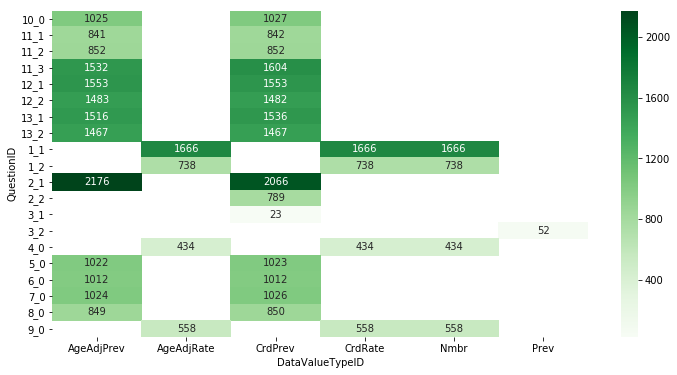

In [21]:
notNullHeatMap(dfDia, "Greens")

In [22]:
dfDia[dfDia['QuestionID'] == 'DIA3_1']['DatavalueFootnote'].value_counts()

No data available    32
Name: DatavalueFootnote, dtype: int64

In [23]:
len(dfDia[(dfDia['QuestionID'] == 'DIA3_2') & dfDia['DataValueAlt'].notnull()]['LocationID'].unique())

52

In [24]:
dfDia[dfDia['QuestionID'] == 'DIA1_1']['DatavalueFootnote'].value_counts()

                                                          4983
Data not shown because of too few respondents or cases    1137
Name: DatavalueFootnote, dtype: int64

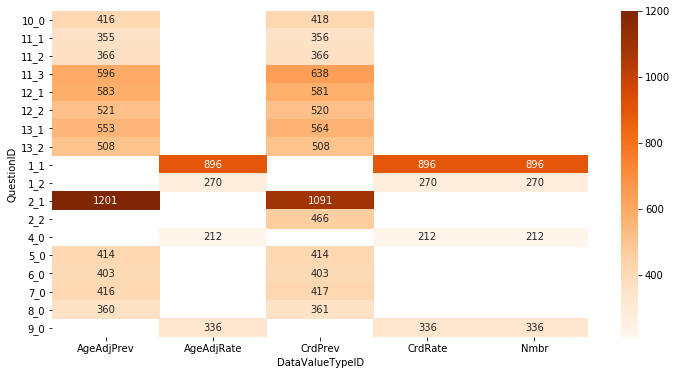

In [25]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'RACE'], "Oranges")

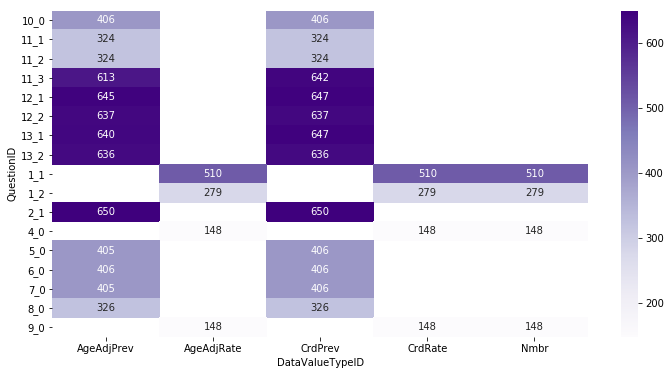

In [26]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'GENDER'], "Purples")

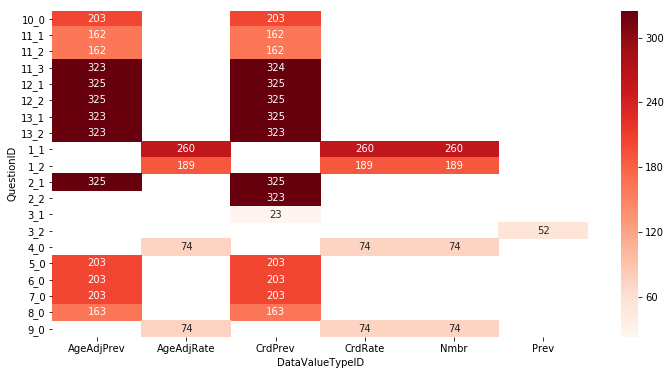

In [27]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'OVERALL'], "Reds")

In [28]:
dfDia[(dfDia['QuestionID'] == 'DIA4_0') & dfDia['DataValueAlt'].notnull() &
      (dfDia['LocationID'] == 8) & (dfDia['StratificationCategoryID1'] == 'OVERALL')].head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
133199,2013,2013,State Inpatient Data,1.76,1.76,,,1.65,1.86,8,DIA,DIA4_0,AgeAdjRate,OVERALL,OVR
133398,2013,2013,State Inpatient Data,1.87,1.87,,,1.76,1.99,8,DIA,DIA4_0,CrdRate,OVERALL,OVR
133599,2013,2013,State Inpatient Data,988,988.00,,,NaN,NaN,8,DIA,DIA4_0,Nmbr,OVERALL,OVR
257444,2010,2010,State Inpatient Data,1.74,1.74,,,1.63,1.86,8,DIA,DIA4_0,AgeAdjRate,OVERALL,OVR
257685,2010,2010,State Inpatient Data,1.76,1.76,,,1.64,1.87,8,DIA,DIA4_0,CrdRate,OVERALL,OVR


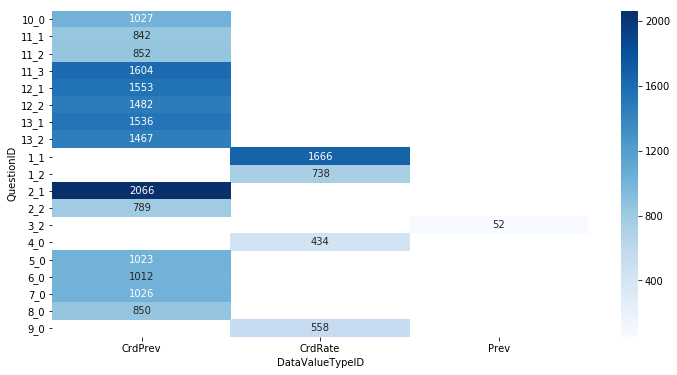

In [29]:
dfOneType = dfDia[(dfDia['QuestionID'] != 'DIA3_1') &
                   dfDia['DataValueTypeID'].isin(['CrdPrev', 'CrdRate', 'Prev'])]
notNullHeatMap(dfOneType)

In [30]:
def notNullBarChart(df, cmap="Blues", figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.barh(df.columns, df.notnull().sum())

In [31]:
def corrHeatMap(df, figsize=(20,20)):
    corr = df.corr(method='pearson')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=figsize)     
    _ = sns.heatmap(corr, mask=mask, cmap=corr_cmap, annot=True, ax=ax)

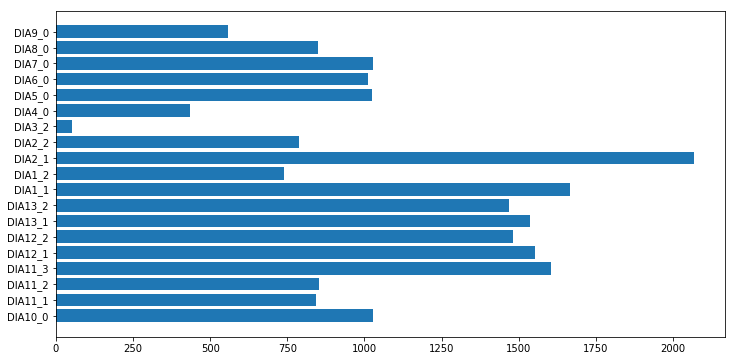

In [32]:
sparsePivot = pd.pivot_table(dfOneType, index=['StratificationCategoryID1', 'StratificationID1',
                                               'LocationID', 'YearStart', 'YearEnd'], 
                             columns='QuestionID', values='DataValueAlt')
sparsePivot = sparsePivot[sparsePivot.notnull().sum(axis=1) > 0]
notNullBarChart(sparsePivot)

In [33]:
sparsePivot.head(10)

QuestionID                                                                DIA10_0  \
StratificationCategoryID1 StratificationID1 LocationID YearStart YearEnd            
GENDER                    GENF              1          2010      2010         NaN   
                                                       2011      2011        52.7   
                                                       2012      2012        55.3   
                                                       2013      2013        54.2   
                                                       2014      2014         NaN   
                                                       2015      2015         NaN   
                                                       2016      2016        54.8   
                                            2          2010      2010         NaN   
                                                       2011      2011        64.5   
                                                       2012      2012        77.9   

QuestionID                                                                DIA11_1  \
StratificationCategoryID1 StratificationID1 LocationID YearStart YearEnd            
GENDER                    GENF              1          2010      2010         NaN   
                                                       2011      2011        72.9   
                                                       2012      2012         NaN   
                                                       2013      2013        70.1   
                                                       2014      2014         NaN   
                                                       2015      2015        67.9   
                                                       2016      2016         NaN   
                                            2          2010      2010         NaN   
                                                       2011      2011        59.0   
                                                       2012      2012         NaN   

QuestionID                                                                DIA11_2  \
StratificationCategoryID1 StratificationID1 LocationID YearStart YearEnd            
GENDER                    GENF              1          2010      2010         NaN   
                                                       2011      2011        78.1   
                                                       2012      2012         NaN   
                                                       2013      2013        79.4   
                                                       2014      2014         NaN   
                                                       2015      2015        78.6   
                                                       2016      2016         NaN   
                                            2          2010      2010         NaN   
                                                       2011      2011        77.2   
                                                       2012      2012         NaN   

QuestionID                                                                DIA11_3  \
StratificationCategoryID1 StratificationID1 LocationID YearStart YearEnd            
GENDER                    GENF              1          2010      2010         NaN   
                                                       2011      2011        33.8   
                                                       2012      2012        36.7   
                                                       2013      2013        35.4   
                                                       2014      2014        35.3   
                                                       2015      2015        38.5   
                                                       2016      2016        40.1   
                                            2          2010      2010         NaN   
                                                       2011      2011        43.6   
  

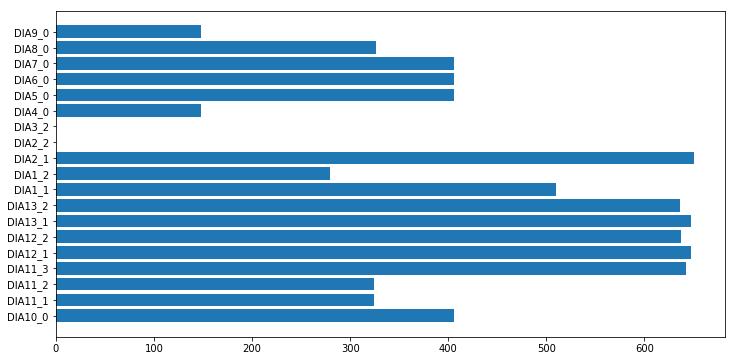

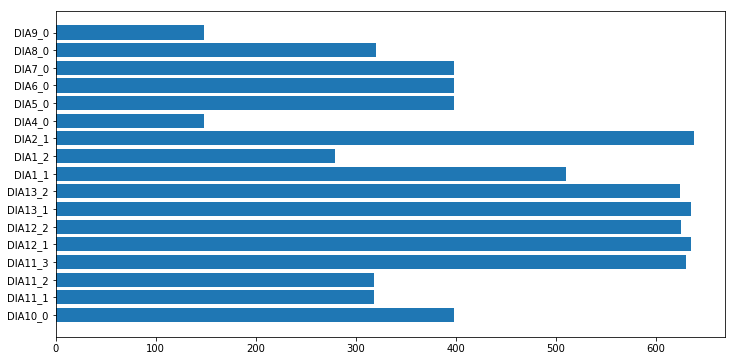

In [36]:
dfGender = sparsePivot.loc['GENDER']
notNullBarChart(dfGender)
dfGender = sparsePivot.loc['GENDER'].drop(['DIA3_2', 'DIA2_2'], axis=1)
dfGender = dfGender[~dfGender.index.isin([59],1)] #location 59 is overall U.S.
notNullBarChart(dfGender)
#corrHeatMap(dfGender)

In [37]:
dfGender[dfGender['DIA9_0'].notnull()].head(10)

QuestionID                                      DIA10_0  DIA11_1  DIA11_2  \
StratificationID1 LocationID YearStart YearEnd                              
GENF              4          2010      2010         NaN      NaN      NaN   
                             2013      2013        56.9     66.6     70.5   
                             2014      2014        57.5      NaN      NaN   
                  5          2010      2010         NaN      NaN      NaN   
                             2013      2013        53.1     63.5     72.3   
                             2014      2014         NaN      NaN      NaN   
                  6          2010      2010         NaN      NaN      NaN   
                  8          2010      2010         NaN      NaN      NaN   
                             2013      2013         NaN     62.2     70.4   
                             2014      2014         NaN      NaN      NaN   

QuestionID                                      DIA11_3  DIA12_1  DIA12_2  \
StratificationID1 LocationID YearStart YearEnd                              
GENF              4          2010      2010         NaN      NaN      NaN   
                             2013      2013        29.8     54.5     63.5   
                             2014      2014        33.2     45.2     60.8   
                  5          2010      2010         NaN      NaN      NaN   
                             2013      2013        37.2     43.4     60.8   
                             2014      2014        34.7     46.8     62.5   
                  6          2010      2010         NaN      NaN      NaN   
                  8          2010      2010         NaN      NaN      NaN   
                             2013      2013        35.6     58.3     69.9   
                             2014      2014        31.6     58.6     68.6   

QuestionID                                      DIA13_1  DIA13_2  DIA1_1  \
StratificationID1 LocationID YearStart YearEnd                             
GENF              4          2010      2010         NaN      NaN    50.4   
                             2013      2013        53.9     80.3    65.1   
                             2014      2014        52.8     75.7    64.8   
                  5          2010      2010         NaN      NaN    78.1   
                             2013      2013        46.3     80.9    79.3   
                             2014      2014        46.2     77.0    78.0   
                  6          2010      2010         NaN      NaN    86.5   
                  8          2010      2010         NaN      NaN    48.7   
                             2013      2013        54.9     86.8    48.3   
                             2014      2014        53.0     86.8    51.1   

QuestionID                                      DIA1_2  DIA2_1  DIA4_0  \
StratificationID1 LocationID YearStart YearEnd                           
GENF              4          2010      2010        0.9     NaN    2.06   
                             2013      2013        0.9    10.0    2.24   
                             2014      2014        1.1     9.3    1.73   
                  5          2010      2010        NaN     NaN    2.88   
                             2013      2013        NaN    10.5    3.04   
                             2014      2014        1.3    12.5    2.42   
                  6          2010      2010        0.8     NaN    1.76   
                  8          2010      2010        NaN     NaN    1.25   
                             2013      2013        0.8     5.9    1.24   
                             2014      2014        0.8     7.0    0.94   

QuestionID                                      DIA5_0  DIA6_0  DIA7_0  \
StratificationID1 LocationID YearStart YearEnd                           
GENF              4          2010      2010        NaN     NaN     NaN   
                             2013      2013       63.6    76.1    70.1   
                             2014      2014       66

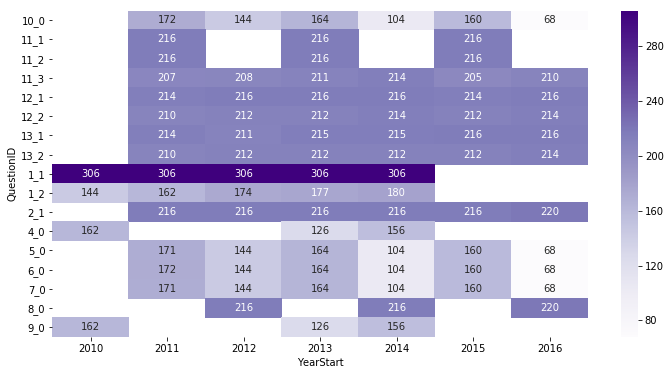

In [584]:
notNullHeatMap(dfDia[dfDia['StratificationCategoryID1'] == 'GENDER'], columns='YearStart', cmap="Purples")

In [38]:
def interpGroup(g):
    g=g.interpolate()
    g=g.interpolate(limit_direction='backward')
    return g
dfInterp = dfGender.copy()
#interpolate across years for the same Gender and Location (maintains differences)
dfInterp = dfInterp.groupby(level=[0,1]).apply(interpGroup)
dfInterp.head(10)

QuestionID                                      DIA10_0  DIA11_1  DIA11_2  \
StratificationID1 LocationID YearStart YearEnd                              
GENF              1          2010      2010        52.7    72.90    78.10   
                             2011      2011        52.7    72.90    78.10   
                             2012      2012        55.3    71.50    78.75   
                             2013      2013        54.2    70.10    79.40   
                             2014      2014        54.4    69.00    79.00   
                             2015      2015        54.6    67.90    78.60   
                             2016      2016        54.8    67.90    78.60   
                  2          2010      2010        64.5    59.00    77.20   
                             2011      2011        64.5    59.00    77.20   
                             2012      2012        77.9    61.45    72.70   

QuestionID                                      DIA11_3  DIA12_1  DIA12_2  \
StratificationID1 LocationID YearStart YearEnd                              
GENF              1          2010      2010        33.8     45.9     66.6   
                             2011      2011        33.8     45.9     66.6   
                             2012      2012        36.7     50.9     66.0   
                             2013      2013        35.4     50.8     59.8   
                             2014      2014        35.3     50.4     70.2   
                             2015      2015        38.5     52.0     60.4   
                             2016      2016        40.1     39.7     59.3   
                  2          2010      2010        43.6     43.9     56.4   
                             2011      2011        43.6     43.9     56.4   
                             2012      2012        34.4     36.7     66.5   

QuestionID                                      DIA13_1  DIA13_2  DIA1_1  \
StratificationID1 LocationID YearStart YearEnd                             
GENF              1          2010      2010        48.0     76.7    85.1   
                             2011      2011        48.0     76.7    79.3   
                             2012      2012        44.8     78.6    76.2   
                             2013      2013        48.3     75.0    74.3   
                             2014      2014        43.9     76.8    65.8   
                             2015      2015        47.5     74.1    65.8   
                             2016      2016        51.3     79.0    65.8   
                  2          2010      2010        63.1     73.7    36.4   
                             2011      2011        63.1     73.7    41.6   
                             2012      2012        41.6     86.3    49.3   

QuestionID                                      DIA1_2  DIA2_1  DIA4_0  \
StratificationID1 LocationID YearStart YearEnd                           
GENF              1          2010      2010        1.4    12.5     NaN   
                             2011      2011        1.4    12.5     NaN   
                             2012      2012        1.3    12.0     NaN   
                             2013      2013        1.7    14.1     NaN   
                             2014      2014        1.5    13.0     NaN   
                             2015      2015        1.5    14.0     NaN   
                             2016      2016        1.5    14.4     NaN   
                  2          2010      2010        NaN     8.2     NaN   
                             2011      2011        NaN     8.2     NaN   
                             2012      2012        NaN     7.4     NaN   

QuestionID                                         DIA5_0     DIA6_0  \
StratificationID1 LocationID YearStart YearEnd                         
GENF              1          2010      2010     65.500000  72.300000   
                             2011      2011     65.500000  72.300000   
                             2012      2012     66.300000  7

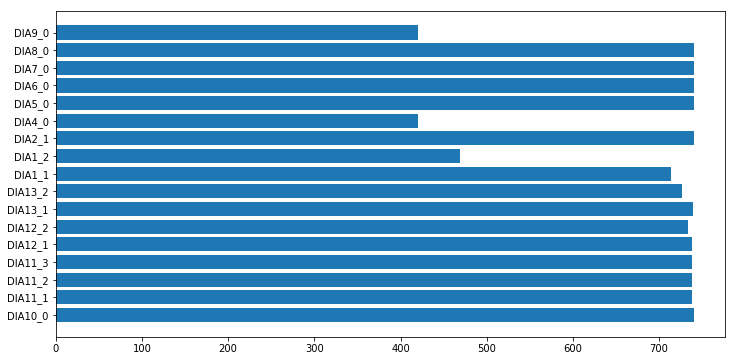

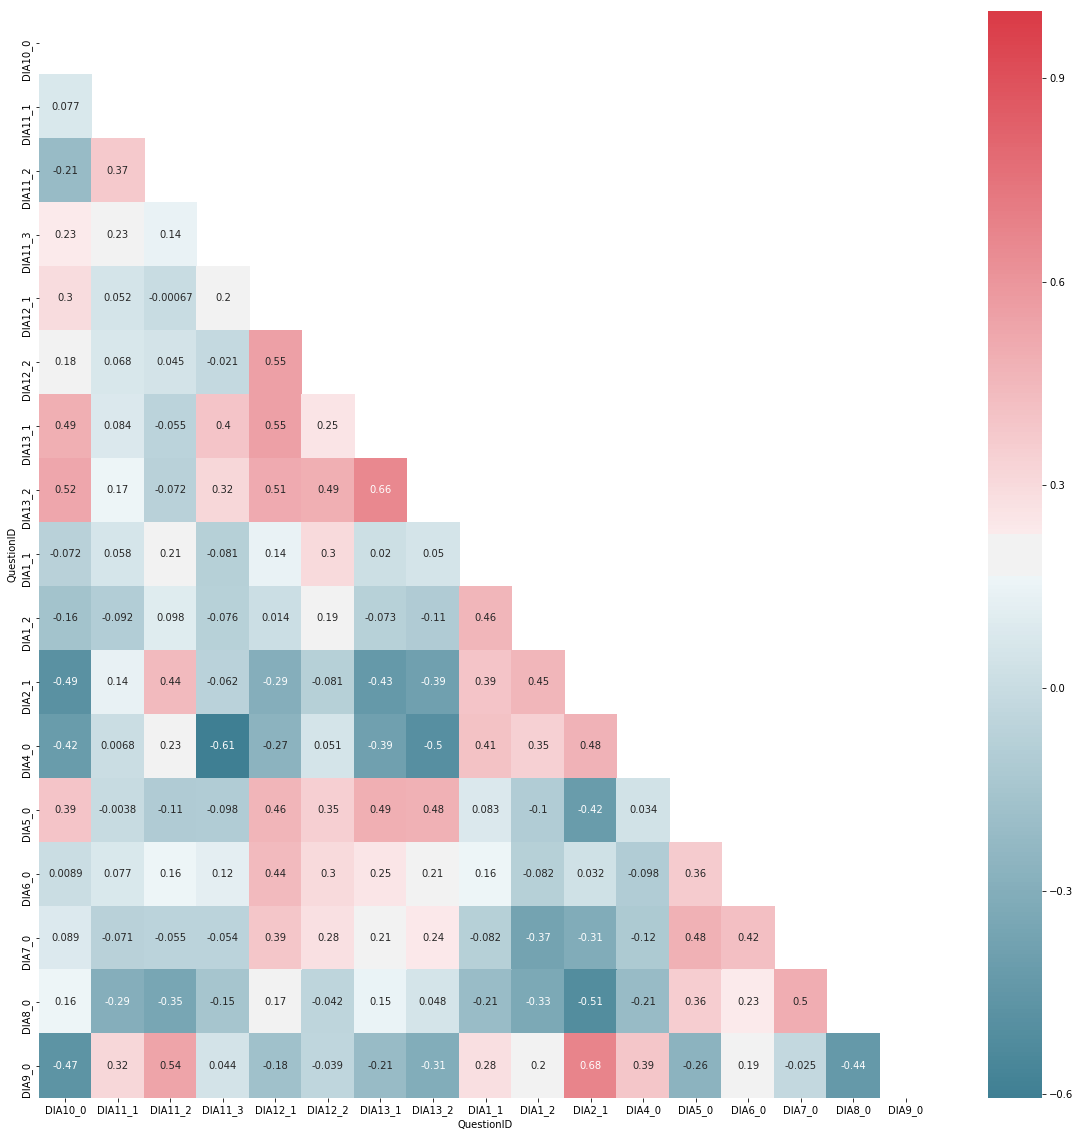

In [39]:
notNullBarChart(dfInterp)
corrHeatMap(dfInterp)

In [650]:
def indicatorFacetGrid(df):
    #instead of sns.pairplot, use sns.FacetGrid: better short hand analysis for distribution 
    g = sns.FacetGrid(pd.melt(df.reset_index(),
                          id_vars=['StratificationID1'],
                          value_vars=dfInterp.columns),
                      hue='StratificationID1',col='QuestionID',col_wrap=6,
                      sharex=False, sharey=False, legend_out=True)
    _ = g.map(sns.kdeplot,'value')

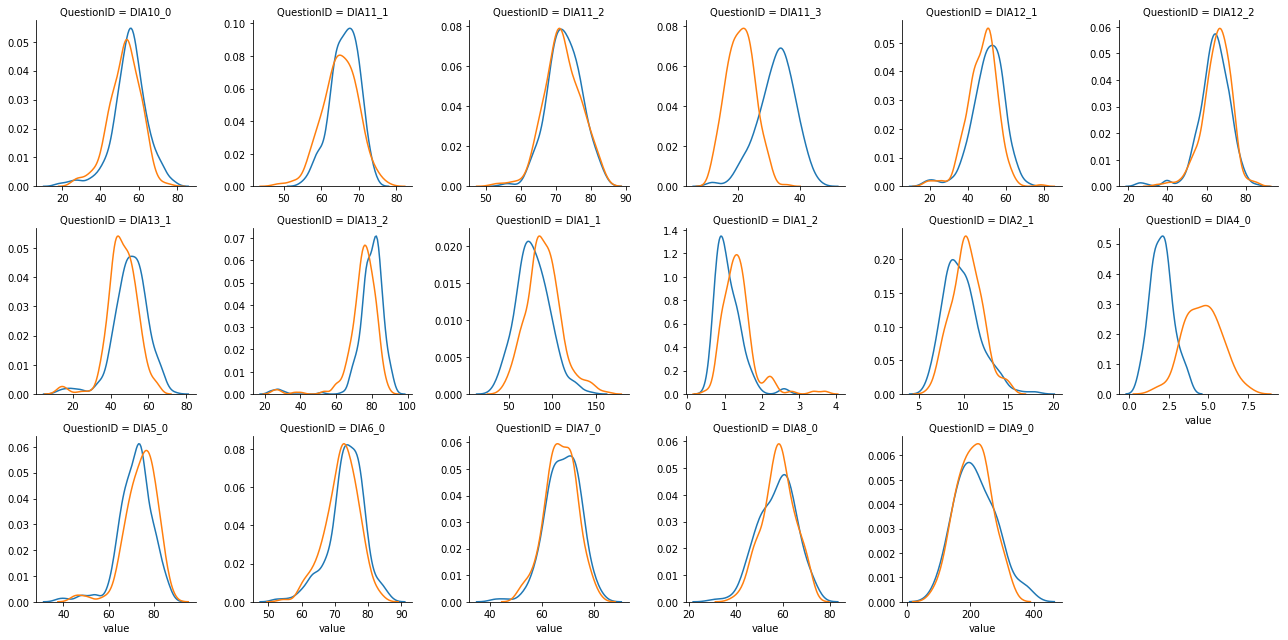

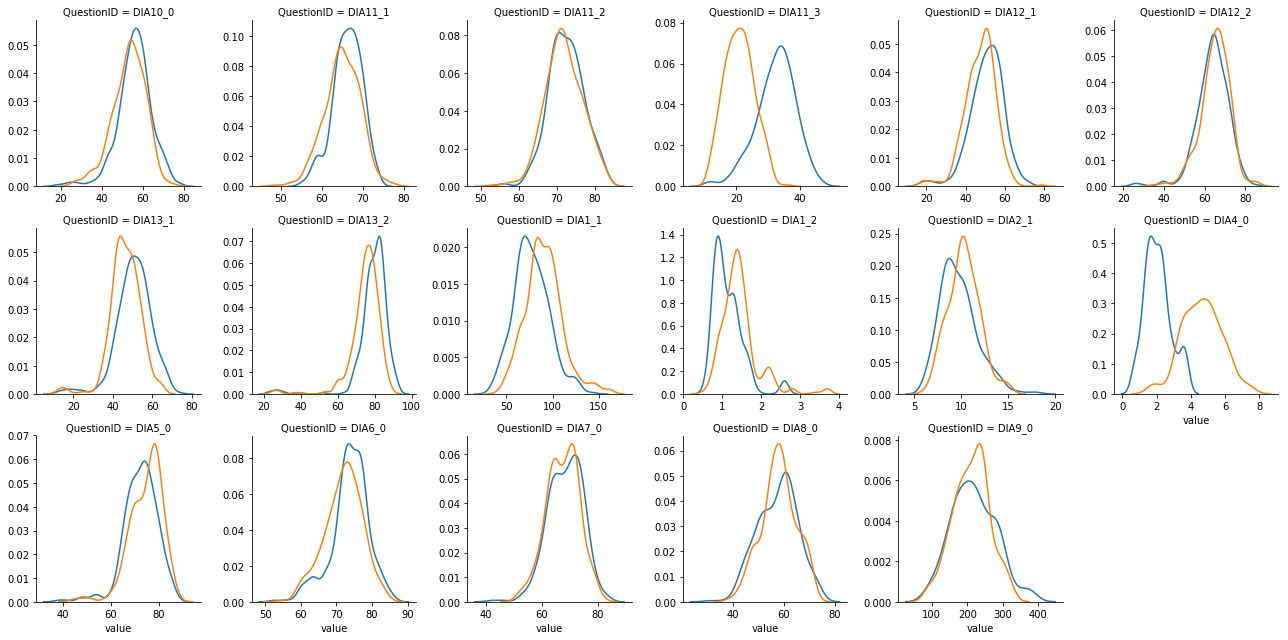

In [646]:
indicatorFacetGrid(dfGender)
indicatorFacetGrid(dfInterp)

In [93]:
predictors = [
    'DIA1_1',
    'DIA1_2',
    #'DIA2_1',
    #'DIA4_0',
    #'DIA5_0',
    #'DIA6_0',
    #'DIA7_0',
    'DIA8_0',
    #'DIA9_0',
    #'DIA10_0',
    #'DIA11_1',
    #'DIA11_2',
    #'DIA12_1',
    #'DIA12_2',
    'DIA13_1',
    'DIA13_2', 
    'StratificationID1', 
    'LocationID',
]
response = 'DIA11_3'
dfIndicators = dfInterp.reset_index()[predictors + [response]] 
print(dfIndicators.shape)
dfIndicatorsNoNAN = dfIndicators.copy().dropna() 
print(dfIndicatorsNoNAN.shape)
dfIndicatorsNoNAN['StratificationID1'] = dfIndicatorsNoNAN['StratificationID1'].replace(['GENM', 'GENF'], [0,1])
X = dfIndicatorsNoNAN[predictors]
y = dfIndicatorsNoNAN[response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
linregr = LinearRegression()
linregr.fit(X_train, y_train)
# Print y-intercept (beta_0)
beta_0 = linregr.intercept_
print("Beta_0 (y-intercept) for %s linear regression model is %0.04f" % (response, beta_0))
for N in range(len(predictors)):
    beta_N = linregr.coef_[N]
    print("Beta_%d (slope) for %s is %0.04f" %(N+1, predictors[N], beta_N))
    if abs(beta_N) < 0.1:
        print("Consider dropping: %s" %(predictors[N]))

y_pred = linregr.predict(X_test)

linModel_score = r2_score(y_test, y_pred)
print ("R^2 score for %s linear regression model is %0.04f" % (response, linModel_score))

(740, 8)
(469, 8)
Beta_0 (y-intercept) for DIA11_3 linear regression model is 4.4121
Beta_1 (slope) for DIA1_1 is 0.0599
Consider dropping: DIA1_1
Beta_2 (slope) for DIA1_2 is 0.9826
Beta_3 (slope) for DIA8_0 is -0.2001
Beta_4 (slope) for DIA13_1 is 0.2416
Beta_5 (slope) for DIA13_2 is 0.1407
Beta_6 (slope) for StratificationID1 is 11.1183
Beta_7 (slope) for LocationID is -0.0201
Consider dropping: LocationID
R^2 score for DIA11_3 linear regression model is 0.7010


In [102]:
from sklearn.model_selection import ShuffleSplit
for folds in range(5,21,5):
    #how CV selects each fold is equivalent of test_train_split fold times to get several selections
    cv = ShuffleSplit(n_splits=folds, test_size=0.3, random_state=42) 
    cv_results = cross_val_score(linregr, X, y, cv = cv, scoring='r2')
    print(np.mean(cv_results))

0.700233780335
0.712965338589
0.711495785776
0.712079009182
